## Python применение продвинутых методов

Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

Mobile Games AB Testing with Cookie Cats

Данная промежуточная аттестация оценивается по системе "зачет" / "не зачет". "Зачет" ставится, если Слушатель успешно выполнил задание. "Незачет" ставится, если Слушатель не выполнил задание.



### Загрузка библиотек

In [1]:
from scipy import stats
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats import proportion
import numpy as np
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
df = pd.read_excel('результаты А_B.xlsx')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


In [5]:
df.shape

(90189, 5)

In [6]:
df.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,9.018900e+04,90189.000000,90189.000000,90189.000000
mean,4.998412e+06,51.872457,0.445210,0.186065
std,2.883286e+06,195.050858,0.496992,0.389161
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.512230e+06,5.000000,0.000000,0.000000
50%,4.995815e+06,16.000000,0.000000,0.000000
75%,7.496452e+06,51.000000,1.000000,0.000000
max,9.999861e+06,49854.000000,1.000000,1.000000


In [7]:
df.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

### Пустых данных в выборке нет.

### Проверим распределение пользователей по группам.

In [8]:
double = df.groupby('userid', as_index=False).agg({'version': pd.Series.nunique}).query('version > 1')
double

,userid,version


### Проверим на полные дубли.

In [9]:
df.duplicated().sum()

0

#### Дубликатов нет. Система сплитования отработана хорошо.

### Посчитаем уникальных записей.

In [10]:
df["userid"].nunique()

90189

In [11]:
df[['sum_gamerounds', 'retention_1', 'retention_7']].describe()

,sum_gamerounds,retention_1,retention_7
count,90189.000000,90189.000000,90189.000000
mean,51.872457,0.445210,0.186065
std,195.050858,0.496992,0.389161
min,0.000000,0.000000,0.000000
25%,5.000000,0.000000,0.000000
50%,16.000000,0.000000,0.000000
75%,51.000000,1.000000,0.000000
max,49854.000000,1.000000,1.000000


### Уберем аномальный выброс в поле sum_gamerounds.

In [12]:
df = df[df['sum_gamerounds'] < 49000]

In [13]:
df['version'].value_counts()

version
gate_40    45489
gate_30    44699
Name: count, dtype: int64

### Количество пользователей примерно одинаковое

In [14]:
df['retention_1'].value_counts()

retention_1
0    50035
1    40153
Name: count, dtype: int64

In [15]:
df['retention_7'].value_counts()

retention_7
0    73408
1    16780
Name: count, dtype: int64

### Поля retention_1 и retention_7 содержит только 0 или 1, ошибок нет.

In [16]:
df.groupby('version').agg({'userid': 'count', 'retention_1': 'mean', 'retention_7': 'mean', 'sum_gamerounds': sum})

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44699,0.448198,0.190183,2294941
gate_40,45489,0.442283,0.182000,2333530


### Найдем значения для A/B теста.

In [17]:
A = df.query('version == "gate_30"')
B = df.query('version == "gate_40"')
n1 = A.shape[0]
n2 = B.shape[0]

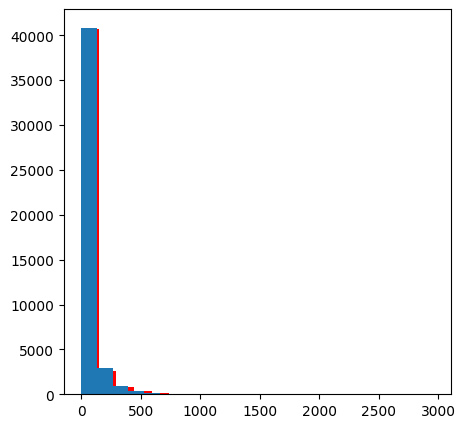

In [18]:
plt.figure(figsize = (5, 5))
control_visit_all = df['sum_gamerounds'][df['version'] == 'gate_30']
test_visit_all = df['sum_gamerounds'][df['version'] == 'gate_40']
plt.hist(control_visit_all, color = 'r',bins = 20)
plt.hist(test_visit_all, bins = 20)
plt.show()

<Axes: xlabel='sum_gamerounds', ylabel='Count'>

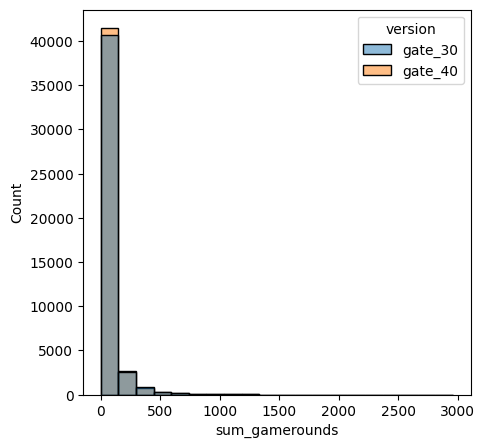

In [19]:
plt.figure(figsize = (5, 5))
sns.histplot(data = df, x = 'sum_gamerounds', bins = 20, hue = 'version')

<Axes: xlabel='version', ylabel='sum_gamerounds'>

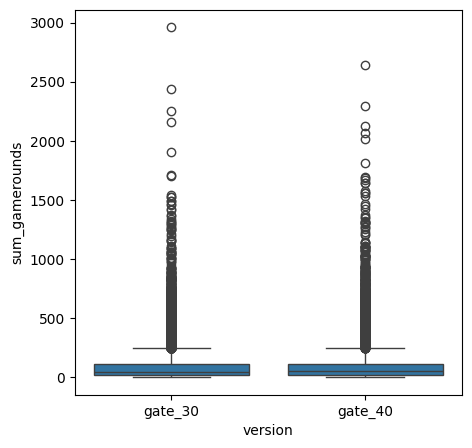

In [21]:
plt.figure(figsize = (5, 5))
sns.boxplot(data = df[df['retention_1'] == 1], y = 'sum_gamerounds', x = 'version')

### По графикам видно, что распределения в обоих группах ненормальные, есть выбросы.

### Для проверки нормальности используем критерий Колмогорова-Смирнова.

In [22]:
stats.kstest(A['sum_gamerounds'], 'norm')

KstestResult(statistic=0.8724153079945488, pvalue=0.0, statistic_location=2, statistic_sign=-1)

In [23]:
stats.kstest(B['sum_gamerounds'], 'norm')

KstestResult(statistic=0.8707186187388001, pvalue=0.0, statistic_location=2, statistic_sign=-1)

### P-value < 0.05 в обоих группах. Данные распределены ненормально, используем критерий Манна-Уитни.

In [24]:
stats.mannwhitneyu(x = A['sum_gamerounds'].values, y = B['sum_gamerounds'].values)

MannwhitneyuResult(statistic=1024285761.5, pvalue=0.05089155279145376)

### При уровне значимости $a$ = 0.05 $p-value$=0.051 больше, следовательно, статистически значимой разницы между группами нет.

### Посчитаем эффективность наших выборок, чтобы анализировать результаты.

In [25]:
M1 = A['sum_gamerounds'].mean() 
M2 = B['sum_gamerounds'].mean()
D1 = A['sum_gamerounds'].var()
D2 = B['sum_gamerounds'].var()

In [26]:
effect_size = (M1 - M2) / np.sqrt(((n1 - 1) * D1 + (n2 - 1) * D2) / (n1 + n2 - 2))
effect_size

0.0004220261663114191

In [27]:
alpha = 0.05
analysis = TTestIndPower()
analysis.solve_power(effect_size = effect_size, alpha = alpha, power = None, nobs1 = n1, ratio = n2 / n1)

0.05046009024737237

### Эффективность теста равна примерно 5%, с такой эффективностью мы не можем быть уверены в результатах теста. Мы могли не получить статистически значимую разницу, т.к. у нас недостаточный объем выборки.

### Рекомендация - проверить длительность теста, чтобы увеличить объем данных и избегать преждевременной остановки теста.

### Проведем тест на возвращение игрока в игру через 1 день после установки.

In [28]:
m1 = A['retention_1'].sum()
m2 = B['retention_1'].sum()

proportion.proportions_ztest(np.array([m1, m2]), np.array([n1, n2]), alternative='two-sided')

(1.787103509763628, 0.0739207603418346)

### При уровне значимости $a$ = 0.05 p-value=0.07 больше, то мы приманием нулевую гипотезу о равенстве доли вернувшихся в игру через 1 день в двух выборках. В группах gate_30 и gate_40 не обнаружены статистически значимые отличия по retention_1.

### Проведем тест на возвращение игрока в игру через 7 день после установки.

In [29]:
m1 = A.query('retention_7 == 1')['retention_7'].sum()
m2 = B.query('retention_7 == 1')['retention_7'].sum()

proportion.proportions_ztest(np.array([m1, m2]), np.array([n1, n2]))

(3.1574100858819936, 0.0015917731773993442)

### При уровне значимости $a$ = 0.05 p-value=0.002 меньше, то мы отвергаем нулевую гипотезу о равенстве доли вернувшихся в игру через 7 день в двух выборках. В группах gate_30 и gate_40 обнаружены статистически значимые отличия по retention_7.